# Disaster Tweet Classification - RidgeClassifierCV
## NLP with Disaster Tweets
------------------
### GOAL
- Predicting whether a given tweet is about a real disaster or not
- if so, predict a `1`. if not, predict a `0`


### Reference
- [competition main page](https://www.kaggle.com/c/nlp-getting-started)
- [example code](https://www.kaggle.com/datarohitingole/disaster-tweet-classification-ridgeclassifiercv)

# 0. Importing Libraries

In [7]:
# for loading and preprocessing the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

# for training the model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree, linear_model, neighbors, naive_bayes, ensemble
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# for evaluating classification model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

# 2. Data Preprocessing
## Contents
1. Dealing with Missing Values
2. Convert Text to Vectors using Count Vectorizer

## Data Description
--------------
### Files
- `train.csv` : the training set
- `test.csv` : the test set
- `sample_submission.csv` : a sample submission file in the correct format

### Columns
- `id` : a unique identifier for each tweet
- `text` : the text of the tweet
- `location` : the location the tweet was sent from 
- `keyword` : a particular keyword from th tweet
- `target` : in train.csv only, this denotes whether a tweet is about a real disaster(1) or not(0)

In [10]:
# loading the .csv form data
data_path = './data/'
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')

all_data = [train,test]

In [11]:
print('train_shape:', train.shape)
print('test_shape;', test.shape)

train_shape: (7613, 5)
test_shape; (3263, 4)


In [12]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 2-1. Dealing with Missing Values

In [14]:
for data in all_data:
    data.drop(["location", "id"], axis = 1, inplace = True)

In [15]:
# data prepocessing with regrex

def remove_URL(text): # remove url pattern in text
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text): # remove html pattern in text
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return html.sub(r'', text)
    #return re.sub(html, '', text)

def remove_punct(text): # remove punctuation in text: (;, ', ", :, ., , etc..)
  table = str.maketrans('', '', string.punctuation)
  return text.translate(table)

In [16]:
for data in all_data:
  data['text'] = data['text'].apply(lambda x: remove_URL(x))
  data['text'] = data['text'].apply(lambda x: remove_html(x))
  data['text'] = data['text'].apply(lambda x: remove_punct(x))

## 2-1. Convert Text to Vectors using Count Vectorizer

### What is the Count Vectorizer?
- convert a collection of text documents to a matrix of token counts

### How to Use
```python
# python example code
corpus = ["This is the first document", "This document is the second document", "And this is the thrid one"]
vectorize = CounterVectorize()
X = vectorize.fit_transform(corpus)
```
- vectorizer.get_feature_names_out()
> array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this'], ...)
- X.toarray()
> [[0 1 1 1 0 0 1 0 1]  
 [0 2 0 1 0 1 1 0 1]  
 [1 0 0 1 1 0 1 1 1]]


In [17]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_features=2000)

X = count_vectorizer.fit_transform(train["text"]).toarray()
test = count_vectorizer.transform(test["text"]).toarray()
y = train['target']

In [18]:
# split the data <train : test = 8 : 2>
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# 3. Model
## Contents
1. Dealing with Missing Values
2. RidgeClassifierCV

## Model Description
--------------
### Ensemble
- Combine the predictions of several base estimators built with a given learning algorithm 
    - in order to improve generalizability / robustness over a single estimator.
- Boosting of Ensemble types
    - 


In [19]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #GLM
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    XGBClassifier(),
    CatBoostClassifier()  
    ]

In [20]:
row_index = 0
MLA_compare = pd.DataFrame()

for classifier in MLA:
  classifier.fit(X_train, y_train)

  y_pred = classifier.predict(X_test)
  classifier_accuracy_score = accuracy_score(y_test, y_pred)

  MLA_name = classifier.__class__.__name__
  MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
  MLA_compare.loc[row_index, 'Accuracy Score'] = classifier_accuracy_score*100

  print(MLA_name, "Done")
  row_index+=1

AdaBoostClassifier Done
BaggingClassifier Done
ExtraTreesClassifier Done
GradientBoostingClassifier Done
RandomForestClassifier Done
PassiveAggressiveClassifier Done
RidgeClassifierCV Done
SGDClassifier Done
Perceptron Done
BernoulliNB Done
GaussianNB Done
KNeighborsClassifier Done
DecisionTreeClassifier Done
ExtraTreeClassifier Done


/Users/mac/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:28:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier Done
Learning rate set to 0.022283
0:	learn: 0.6903304	total: 59.3ms	remaining: 59.2s
1:	learn: 0.6870982	total: 66.9ms	remaining: 33.4s
2:	learn: 0.6849708	total: 74.1ms	remaining: 24.6s
3:	learn: 0.6825957	total: 81.8ms	remaining: 20.4s
4:	learn: 0.6801002	total: 89.1ms	remaining: 17.7s
5:	learn: 0.6779782	total: 96.5ms	remaining: 16s
6:	learn: 0.6755461	total: 104ms	remaining: 14.7s
7:	learn: 0.6734505	total: 111ms	remaining: 13.8s
8:	learn: 0.6711925	total: 119ms	remaining: 13.1s
9:	learn: 0.6695775	total: 126ms	remaining: 12.5s
10:	learn: 0.6681076	total: 133ms	remaining: 12s
11:	learn: 0.6663797	total: 141ms	remaining: 11.6s
12:	learn: 0.6645189	total: 149ms	remaining: 11.3s
13:	learn: 0.6

163:	learn: 0.5620459	total: 1.33s	remaining: 6.77s
164:	learn: 0.5617955	total: 1.34s	remaining: 6.76s
165:	learn: 0.5615760	total: 1.34s	remaining: 6.75s
166:	learn: 0.5612824	total: 1.35s	remaining: 6.74s
167:	learn: 0.5610545	total: 1.36s	remaining: 6.73s
168:	learn: 0.5607437	total: 1.37s	remaining: 6.72s
169:	learn: 0.5603084	total: 1.38s	remaining: 6.72s
170:	learn: 0.5599545	total: 1.38s	remaining: 6.71s
171:	learn: 0.5595440	total: 1.39s	remaining: 6.7s
172:	learn: 0.5593027	total: 1.4s	remaining: 6.69s
173:	learn: 0.5589166	total: 1.41s	remaining: 6.68s
174:	learn: 0.5584885	total: 1.42s	remaining: 6.67s
175:	learn: 0.5580834	total: 1.42s	remaining: 6.66s
176:	learn: 0.5577275	total: 1.43s	remaining: 6.66s
177:	learn: 0.5572540	total: 1.44s	remaining: 6.65s
178:	learn: 0.5568599	total: 1.45s	remaining: 6.64s
179:	learn: 0.5564836	total: 1.46s	remaining: 6.63s
180:	learn: 0.5561678	total: 1.46s	remaining: 6.63s
181:	learn: 0.5557810	total: 1.47s	remaining: 6.62s
182:	learn: 0.

337:	learn: 0.5168771	total: 2.71s	remaining: 5.31s
338:	learn: 0.5166571	total: 2.72s	remaining: 5.3s
339:	learn: 0.5164035	total: 2.73s	remaining: 5.3s
340:	learn: 0.5162244	total: 2.74s	remaining: 5.29s
341:	learn: 0.5159779	total: 2.75s	remaining: 5.28s
342:	learn: 0.5157894	total: 2.75s	remaining: 5.27s
343:	learn: 0.5155649	total: 2.76s	remaining: 5.26s
344:	learn: 0.5153822	total: 2.77s	remaining: 5.26s
345:	learn: 0.5151768	total: 2.78s	remaining: 5.25s
346:	learn: 0.5149980	total: 2.78s	remaining: 5.24s
347:	learn: 0.5147583	total: 2.79s	remaining: 5.23s
348:	learn: 0.5146241	total: 2.8s	remaining: 5.22s
349:	learn: 0.5145155	total: 2.81s	remaining: 5.21s
350:	learn: 0.5143010	total: 2.82s	remaining: 5.21s
351:	learn: 0.5141369	total: 2.82s	remaining: 5.2s
352:	learn: 0.5138862	total: 2.83s	remaining: 5.19s
353:	learn: 0.5136746	total: 2.84s	remaining: 5.18s
354:	learn: 0.5134407	total: 2.85s	remaining: 5.17s
355:	learn: 0.5132453	total: 2.85s	remaining: 5.16s
356:	learn: 0.51

518:	learn: 0.4771554	total: 4.1s	remaining: 3.8s
519:	learn: 0.4769354	total: 4.11s	remaining: 3.79s
520:	learn: 0.4767043	total: 4.11s	remaining: 3.78s
521:	learn: 0.4765092	total: 4.12s	remaining: 3.77s
522:	learn: 0.4763250	total: 4.13s	remaining: 3.77s
523:	learn: 0.4760796	total: 4.14s	remaining: 3.76s
524:	learn: 0.4759195	total: 4.15s	remaining: 3.75s
525:	learn: 0.4757476	total: 4.16s	remaining: 3.75s
526:	learn: 0.4754734	total: 4.16s	remaining: 3.74s
527:	learn: 0.4752508	total: 4.17s	remaining: 3.73s
528:	learn: 0.4750458	total: 4.18s	remaining: 3.72s
529:	learn: 0.4748347	total: 4.19s	remaining: 3.71s
530:	learn: 0.4746584	total: 4.2s	remaining: 3.71s
531:	learn: 0.4743815	total: 4.2s	remaining: 3.7s
532:	learn: 0.4741424	total: 4.21s	remaining: 3.69s
533:	learn: 0.4739360	total: 4.22s	remaining: 3.68s
534:	learn: 0.4736885	total: 4.23s	remaining: 3.67s
535:	learn: 0.4735299	total: 4.24s	remaining: 3.67s
536:	learn: 0.4733006	total: 4.24s	remaining: 3.66s
537:	learn: 0.473

699:	learn: 0.4444686	total: 5.48s	remaining: 2.35s
700:	learn: 0.4443042	total: 5.49s	remaining: 2.34s
701:	learn: 0.4441406	total: 5.5s	remaining: 2.33s
702:	learn: 0.4439837	total: 5.51s	remaining: 2.33s
703:	learn: 0.4438049	total: 5.51s	remaining: 2.32s
704:	learn: 0.4436501	total: 5.52s	remaining: 2.31s
705:	learn: 0.4434917	total: 5.53s	remaining: 2.3s
706:	learn: 0.4433176	total: 5.54s	remaining: 2.29s
707:	learn: 0.4431577	total: 5.54s	remaining: 2.29s
708:	learn: 0.4430259	total: 5.55s	remaining: 2.28s
709:	learn: 0.4429375	total: 5.56s	remaining: 2.27s
710:	learn: 0.4427737	total: 5.57s	remaining: 2.26s
711:	learn: 0.4426066	total: 5.58s	remaining: 2.25s
712:	learn: 0.4424643	total: 5.58s	remaining: 2.25s
713:	learn: 0.4422381	total: 5.59s	remaining: 2.24s
714:	learn: 0.4420945	total: 5.6s	remaining: 2.23s
715:	learn: 0.4419262	total: 5.61s	remaining: 2.22s
716:	learn: 0.4417283	total: 5.62s	remaining: 2.22s
717:	learn: 0.4415362	total: 5.62s	remaining: 2.21s
718:	learn: 0.4

880:	learn: 0.4188275	total: 6.88s	remaining: 929ms
881:	learn: 0.4186957	total: 6.88s	remaining: 921ms
882:	learn: 0.4185802	total: 6.89s	remaining: 913ms
883:	learn: 0.4184663	total: 6.9s	remaining: 905ms
884:	learn: 0.4182977	total: 6.91s	remaining: 898ms
885:	learn: 0.4181407	total: 6.92s	remaining: 890ms
886:	learn: 0.4179913	total: 6.92s	remaining: 882ms
887:	learn: 0.4178594	total: 6.93s	remaining: 874ms
888:	learn: 0.4176942	total: 6.94s	remaining: 866ms
889:	learn: 0.4175421	total: 6.95s	remaining: 859ms
890:	learn: 0.4173961	total: 6.95s	remaining: 851ms
891:	learn: 0.4172809	total: 6.96s	remaining: 843ms
892:	learn: 0.4171313	total: 6.97s	remaining: 835ms
893:	learn: 0.4169826	total: 6.98s	remaining: 827ms
894:	learn: 0.4168550	total: 6.98s	remaining: 819ms
895:	learn: 0.4167148	total: 6.99s	remaining: 812ms
896:	learn: 0.4165476	total: 7s	remaining: 804ms
897:	learn: 0.4164115	total: 7.01s	remaining: 796ms
898:	learn: 0.4162516	total: 7.01s	remaining: 788ms
899:	learn: 0.41

In [21]:
MLA_compare = MLA_compare.sort_values(by="Accuracy Score", ascending=False).reset_index(drop=True)
MLA_compare

,MLA Name,Accuracy Score
0,RandomForestClassifier,79.645437
1,RidgeClassifierCV,79.645437
2,BernoulliNB,79.645437
3,XGBClassifier,78.791858
4,ExtraTreesClassifier,78.726198
5,CatBoostClassifier,78.660538
6,SGDClassifier,77.938280
7,BaggingClassifier,76.822062
8,GaussianNB,76.690742
9,AdaBoostClassifier,75.968483


Text(0.5, 0, 'Algorithm Name')

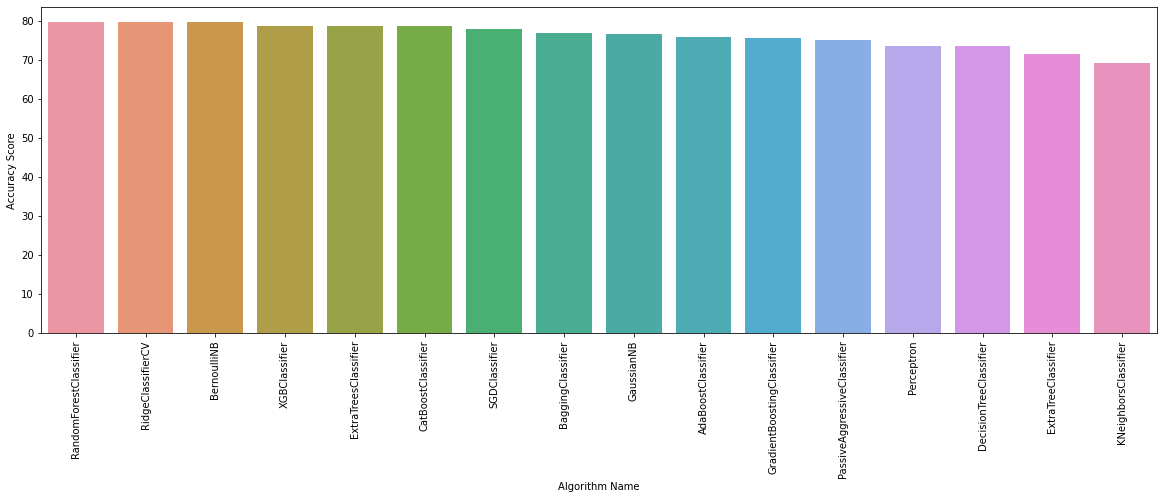

In [22]:
plt.rcParams["figure.figsize"] = (20,6)
sns.barplot(x="MLA Name", y="Accuracy Score", data = MLA_compare)
plt.xticks(rotation=90)
plt.xlabel("Algorithm Name")

In [23]:
classifier = linear_model.RidgeClassifierCV(cv=15)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Accuracy Score : ", accuracy_score(y_test, y_pred), "\n\n")
print(confusion_matrix(y_test, y_pred))

Accuracy Score :  0.7964543663821405 


[[789  97]
 [213 424]]


In [25]:
sample_submission = pd.read_csv(data_path + "sample_submission.csv")
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [26]:
test_pred = classifier.predict(test)

In [27]:
output = pd.DataFrame({'id': sample_submission.id, 'target': test_pred})
output.to_csv(data_path+'submission.csv', index=False)